<a href="https://colab.research.google.com/github/Rogerio-mack/Deep-Learning-I/blob/main/T4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<h1 align=left><font size = 8, style="color:rgb(200,0,0)"><b>Inteligência Artificial</b></font></h1> 
<h1 align=left><font size = 6, style="color:rgb(0,0,0)"><b>Deep Learning</b></font></h1> 

Professor. Dr. Rogério de Oliveira

TURMA 01A – MATRÍCULA 92104843
Fernando Antonio Carvalho Pessoa

Tarefa da trilha 6: classificação binária ou multiclasse com o PyTorch
<br>
https://github.com/Fernandopessoa1959/MACKENZIE-IA
<br>
NOTEBOOK https://github.com/Fernandopessoa1959/MACKENZIE-IA/blob/main/TRILHA_6_TAREFA_FERNANDO_PESSOA.ipynb
<br>
DATASET https://github.com/Fernandopessoa1959/MACKENZIE-IA/blob/main/TRILHA_6_MLW_Data.csv
<br>
---


# Introdução

Nesta tarefa devemos implementar um modelo de classificação binária ou multiclasse para um conjunto de dados `TensorFlow` e o `Keras`. 



#Dataset

O dataset escolhido é o MLW_Data, este dataset fornecido pela Agência Europeia de Ambiente, é criado a partir de um aplicativo denominado LitterWatch, que é utilizados nas comunidades costeiras da Europa para identificar o lixo jogado ao oceano.

##Fonte da base
https://www.eea.europa.eu/data-and-maps/data/marine-litter

##Visualização por TABLEAU
https://www.eea.europa.eu/themes/water/europes-seas-and-coasts/assessments/marine-litterwatch/data-and-results/marine-litterwatch-data-viewer/marine-litterwatch-data-viewer

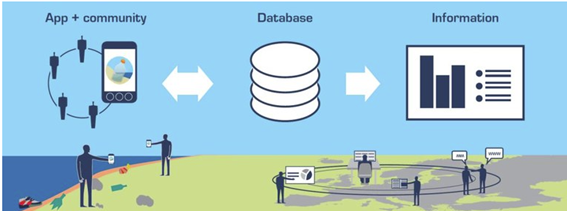<img src="c:/imagens/LitterWatch.png" width=300, align="right">


#Objetivo do modelo

Tendo o levantamento do lixo, por tipo e quantidade, localizado em cada comunidade, nosso objetivo é treinar o modelo para identificar e categoraizar o local como POLUIDO ou LIMPO

#Importando Bibliotecas

In [4]:
import pandas as pd
import torch
from torch import nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Importando datasets
Carregando os dados coletados no aplicativo e a tabela de categorias de lixo

##Base de dados da pesquisa

In [5]:
# carregando o arquivo dados para o Google Colab
from google.colab import files
uploaded = files.upload()

Saving TRILHA_6_MLW_Data.csv to TRILHA_6_MLW_Data (1).csv


In [6]:
data = pd.read_csv('/content/TRILHA_6_MLW_Data.csv', engine= 'python', sep = ';', encoding='latin-1')

In [7]:
data.shape

(254, 178)

In [8]:
data.head(5)

,CommunityName,BeachName,BeachCountrycode,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,lon_x1,lat_y1,lon_x2,lat_y2,Unnamed: 14,G1,G3,G4,G5,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19,G21,G22,G23,G24,G25,G26,G27,G28,...,G164,G165,G166,G167,G171,G172,G174,G175,G176,G177,G178,G179,G180,G181,G182,G184,G186,G187,G188,G189,G190,G191,G193,G194,G195,G198,G199,G200,G201,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213,CLASSE
0,gBqsPxAZ,Neum,BA,Mediterranean Sea,1551.0,Urban,Other (mixed),20160424.0,Cleanup,NaN,17.619.790.849.047.900,4.291.792.327.340.360,17.607.699.422.017.400,4.292.868.771.626.050,NaN,NaN,37.0,15.0,NaN,56.0,17.0,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,895.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0,NaN,NaN,NaN,LIMPO
1,gBqsPxAZ,Ponton,BA,NaN,86.0,Urban,Other (mixed),20160519.0,Cleanup,NaN,1.910.840.665.135.820,44.368.655.173.785.800,19.109.083.858.013.200,44.369.255.678.908.900,NaN,NaN,10.0,3.0,NaN,148.0,144.0,8.0,33.0,NaN,6.0,NaN,6.0,NaN,NaN,1.0,NaN,NaN,350.0,NaN,NaN,NaN,NaN,2.0,24.0,NaN,...,NaN,NaN,NaN,NaN,44.0,32.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,POLUIDO
2,Surfrider Foundation Europe,Blakenberg beach,BE,North-east Atlantic Ocean,82.0,Urban,Sandy,20160812.0,Cleanup,NaN,29.747.061.142.684.500,51.255.998.063.635.000,29.755.869.645.068.000,5.125.649.888.395.530,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIMPO
3,Perseus,Alepu,BG,Black Sea,105.0,Rural,Sandy,20160317.0,Cleanup,NaN,2.770.921.843.173.200,42.367.082.331.608.300,2.770.950.128.606.210,4.236.616.387.533.450,NaN,NaN,NaN,2.0,NaN,5.0,1.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,LIMPO
4,gBqsPxAZ,alepu,BG,Black Sea,2779.0,Urban,Sandy,20160313.0,Cleanup,NaN,27.722.467.974.911.600,4.234.864.091.261.680,2.771.062.971.738.270,4.237.205.899.301.860,NaN,NaN,26.0,NaN,NaN,14.0,16.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,36.0,4.0,32.0,36.0,2.0,1.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,NaN,NaN,POLUIDO


###Pré processamento da base

O objetivo desta etapa é tratar, preparar e montar os dados coletados em uma base para aplicação do algoritmo Keras - TensorFlow

In [9]:
#Verifica valores NAN
data.isnull().sum()

CommunityName         1
BeachName             1
BeachCountrycode      1
BeachRegionalSea      2
BeachLength_m         1
                   ... 
G208                147
G210                216
G211                208
G213                235
CLASSE                0
Length: 178, dtype: int64

In [10]:
data.head()

,CommunityName,BeachName,BeachCountrycode,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,lon_x1,lat_y1,lon_x2,lat_y2,Unnamed: 14,G1,G3,G4,G5,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19,G21,G22,G23,G24,G25,G26,G27,G28,...,G164,G165,G166,G167,G171,G172,G174,G175,G176,G177,G178,G179,G180,G181,G182,G184,G186,G187,G188,G189,G190,G191,G193,G194,G195,G198,G199,G200,G201,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213,CLASSE
0,gBqsPxAZ,Neum,BA,Mediterranean Sea,1551.0,Urban,Other (mixed),20160424.0,Cleanup,NaN,17.619.790.849.047.900,4.291.792.327.340.360,17.607.699.422.017.400,4.292.868.771.626.050,NaN,NaN,37.0,15.0,NaN,56.0,17.0,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,895.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0,NaN,NaN,NaN,LIMPO
1,gBqsPxAZ,Ponton,BA,NaN,86.0,Urban,Other (mixed),20160519.0,Cleanup,NaN,1.910.840.665.135.820,44.368.655.173.785.800,19.109.083.858.013.200,44.369.255.678.908.900,NaN,NaN,10.0,3.0,NaN,148.0,144.0,8.0,33.0,NaN,6.0,NaN,6.0,NaN,NaN,1.0,NaN,NaN,350.0,NaN,NaN,NaN,NaN,2.0,24.0,NaN,...,NaN,NaN,NaN,NaN,44.0,32.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,POLUIDO
2,Surfrider Foundation Europe,Blakenberg beach,BE,North-east Atlantic Ocean,82.0,Urban,Sandy,20160812.0,Cleanup,NaN,29.747.061.142.684.500,51.255.998.063.635.000,29.755.869.645.068.000,5.125.649.888.395.530,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIMPO
3,Perseus,Alepu,BG,Black Sea,105.0,Rural,Sandy,20160317.0,Cleanup,NaN,2.770.921.843.173.200,42.367.082.331.608.300,2.770.950.128.606.210,4.236.616.387.533.450,NaN,NaN,NaN,2.0,NaN,5.0,1.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,LIMPO
4,gBqsPxAZ,alepu,BG,Black Sea,2779.0,Urban,Sandy,20160313.0,Cleanup,NaN,27.722.467.974.911.600,4.234.864.091.261.680,2.771.062.971.738.270,4.237.205.899.301.860,NaN,NaN,26.0,NaN,NaN,14.0,16.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,36.0,4.0,32.0,36.0,2.0,1.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,NaN,NaN,POLUIDO


In [11]:
#Substitui os valores NAN por zero
dataT = data.fillna(0)
dataT.isnull().sum()

CommunityName       0
BeachName           0
BeachCountrycode    0
BeachRegionalSea    0
BeachLength_m       0
                   ..
G208                0
G210                0
G211                0
G213                0
CLASSE              0
Length: 178, dtype: int64

In [12]:
dataT.head()

,CommunityName,BeachName,BeachCountrycode,BeachRegionalSea,BeachLength_m,BeachLocation,BeachType,EventDate,EventType,NatRef,lon_x1,lat_y1,lon_x2,lat_y2,Unnamed: 14,G1,G3,G4,G5,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19,G21,G22,G23,G24,G25,G26,G27,G28,...,G164,G165,G166,G167,G171,G172,G174,G175,G176,G177,G178,G179,G180,G181,G182,G184,G186,G187,G188,G189,G190,G191,G193,G194,G195,G198,G199,G200,G201,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213,CLASSE
0,gBqsPxAZ,Neum,BA,Mediterranean Sea,1551.0,Urban,Other (mixed),20160424.0,Cleanup,0,17.619.790.849.047.900,4.291.792.327.340.360,17.607.699.422.017.400,4.292.868.771.626.050,0.0,0.0,37.0,15.0,0.0,56.0,17.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,895.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,LIMPO
1,gBqsPxAZ,Ponton,BA,0,86.0,Urban,Other (mixed),20160519.0,Cleanup,0,1.910.840.665.135.820,44.368.655.173.785.800,19.109.083.858.013.200,44.369.255.678.908.900,0.0,0.0,10.0,3.0,0.0,148.0,144.0,8.0,33.0,0.0,6.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,350.0,0.0,0.0,0.0,0.0,2.0,24.0,0.0,...,0.0,0.0,0.0,0.0,44.0,32.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,POLUIDO
2,Surfrider Foundation Europe,Blakenberg beach,BE,North-east Atlantic Ocean,82.0,Urban,Sandy,20160812.0,Cleanup,0,29.747.061.142.684.500,51.255.998.063.635.000,29.755.869.645.068.000,5.125.649.888.395.530,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LIMPO
3,Perseus,Alepu,BG,Black Sea,105.0,Rural,Sandy,20160317.0,Cleanup,0,2.770.921.843.173.200,42.367.082.331.608.300,2.770.950.128.606.210,4.236.616.387.533.450,0.0,0.0,0.0,2.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,LIMPO
4,gBqsPxAZ,alepu,BG,Black Sea,2779.0,Urban,Sandy,20160313.0,Cleanup,0,27.722.467.974.911.600,4.234.864.091.261.680,2.771.062.971.738.270,4.237.205.899.301.860,0.0,0.0,26.0,0.0,0.0,14.0,16.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36.0,4.0,32.0,36.0,2.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,POLUIDO


## Preparando os Dados 

As colunas que precisamos são os indicadores de poluição (coluna G1 a G213) e a coluna de atributo Poluido = 1 não poluido = 0

Também necessitamos susbtituir as quantidades das colunas G1 a g213 por atributo do tipo de poluente encontrado=1 ou não encontrado=0

###Eliminando colunas

In [13]:
dataT1 =  dataT.drop(columns=['CommunityName','BeachName','BeachCountrycode','BeachRegionalSea','BeachLength_m','BeachLocation','BeachType','EventDate','EventType','NatRef','lon_x1','lat_y1','lon_x2','lat_y2','Unnamed: 14'])
dataT1.head()

,G1,G3,G4,G5,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19,G21,G22,G23,G24,G25,G26,G27,G28,G29,G30,G31,G32,G33,G34,G35,G36,G37,G40,G41,G42,G43,G44,G45,...,G164,G165,G166,G167,G171,G172,G174,G175,G176,G177,G178,G179,G180,G181,G182,G184,G186,G187,G188,G189,G190,G191,G193,G194,G195,G198,G199,G200,G201,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213,CLASSE
0,0.0,37.0,15.0,0.0,56.0,17.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,895.0,0.0,0.0,28.0,0.0,0.0,0.0,70.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,LIMPO
1,0.0,10.0,3.0,0.0,148.0,144.0,8.0,33.0,0.0,6.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,350.0,0.0,0.0,0.0,0.0,2.0,24.0,0.0,0.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,44.0,32.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,POLUIDO
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LIMPO
3,0.0,0.0,2.0,0.0,5.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,LIMPO
4,0.0,26.0,0.0,0.0,14.0,16.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,36.0,4.0,32.0,36.0,2.0,1.0,20.0,0.0,0.0,13.0,3.0,5.0,17.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,POLUIDO


###Encode das quantidade do tipo de lixo para localizado=1 não localizado=0

In [14]:
dataT1.loc[dataT1.G1>1,'G1']=1
dataT1.loc[dataT1.G3>1,'G3']=1
dataT1.loc[dataT1.G4>1,'G4']=1
dataT1.loc[dataT1.G5>1,'G5']=1
dataT1.loc[dataT1.G7>1,'G7']=1
dataT1.loc[dataT1.G8>1,'G8']=1
dataT1.loc[dataT1.G9>1,'G9']=1
dataT1.loc[dataT1.G10>1,'G10']=1
dataT1.loc[dataT1.G11>1,'G11']=1
dataT1.loc[dataT1.G12>1,'G12']=1
dataT1.loc[dataT1.G13>1,'G13']=1
dataT1.loc[dataT1.G14>1,'G14']=1
dataT1.loc[dataT1.G15>1,'G15']=1
dataT1.loc[dataT1.G16>1,'G16']=1
dataT1.loc[dataT1.G17>1,'G17']=1
dataT1.loc[dataT1.G18>1,'G18']=1
dataT1.loc[dataT1.G19>1,'G19']=1
dataT1.loc[dataT1.G21>1,'G21']=1
dataT1.loc[dataT1.G22>1,'G22']=1
dataT1.loc[dataT1.G23>1,'G23']=1
dataT1.loc[dataT1.G24>1,'G24']=1
dataT1.loc[dataT1.G25>1,'G25']=1
dataT1.loc[dataT1.G26>1,'G26']=1
dataT1.loc[dataT1.G27>1,'G27']=1
dataT1.loc[dataT1.G28>1,'G28']=1
dataT1.loc[dataT1.G29>1,'G29']=1
dataT1.loc[dataT1.G30>1,'G30']=1
dataT1.loc[dataT1.G31>1,'G31']=1
dataT1.loc[dataT1.G32>1,'G32']=1
dataT1.loc[dataT1.G33>1,'G33']=1
dataT1.loc[dataT1.G34>1,'G34']=1
dataT1.loc[dataT1.G35>1,'G35']=1
dataT1.loc[dataT1.G36>1,'G36']=1
dataT1.loc[dataT1.G37>1,'G37']=1
dataT1.loc[dataT1.G40>1,'G40']=1
dataT1.loc[dataT1.G41>1,'G41']=1
dataT1.loc[dataT1.G42>1,'G42']=1
dataT1.loc[dataT1.G43>1,'G43']=1
dataT1.loc[dataT1.G44>1,'G44']=1
dataT1.loc[dataT1.G45>1,'G45']=1
dataT1.loc[dataT1.G46>1,'G46']=1
dataT1.loc[dataT1.G47>1,'G47']=1
dataT1.loc[dataT1.G49>1,'G49']=1
dataT1.loc[dataT1.G50>1,'G50']=1
dataT1.loc[dataT1.G52>1,'G52']=1
dataT1.loc[dataT1.G53>1,'G53']=1
dataT1.loc[dataT1.G54>1,'G54']=1
dataT1.loc[dataT1.G56>1,'G56']=1
dataT1.loc[dataT1.G57>1,'G57']=1
dataT1.loc[dataT1.G58>1,'G58']=1
dataT1.loc[dataT1.G59>1,'G59']=1
dataT1.loc[dataT1.G60>1,'G60']=1
dataT1.loc[dataT1.G62>1,'G62']=1
dataT1.loc[dataT1.G63>1,'G63']=1
dataT1.loc[dataT1.G64>1,'G64']=1
dataT1.loc[dataT1.G65>1,'G65']=1
dataT1.loc[dataT1.G66>1,'G66']=1
dataT1.loc[dataT1.G67>1,'G67']=1
dataT1.loc[dataT1.G68>1,'G68']=1
dataT1.loc[dataT1.G69>1,'G69']=1
dataT1.loc[dataT1.G70>1,'G70']=1
dataT1.loc[dataT1.G71>1,'G71']=1
dataT1.loc[dataT1.G72>1,'G72']=1
dataT1.loc[dataT1.G73>1,'G73']=1
dataT1.loc[dataT1.G76>1,'G76']=1
dataT1.loc[dataT1.G77>1,'G77']=1
dataT1.loc[dataT1.G79>1,'G79']=1
dataT1.loc[dataT1.G80>1,'G80']=1
dataT1.loc[dataT1.G82>1,'G82']=1
dataT1.loc[dataT1.G83>1,'G83']=1
dataT1.loc[dataT1.G84>1,'G84']=1
dataT1.loc[dataT1.G85>1,'G85']=1
dataT1.loc[dataT1.G86>1,'G86']=1
dataT1.loc[dataT1.G87>1,'G87']=1
dataT1.loc[dataT1.G88>1,'G88']=1
dataT1.loc[dataT1.G89>1,'G89']=1
dataT1.loc[dataT1.G90>1,'G90']=1
dataT1.loc[dataT1.G91>1,'G91']=1
dataT1.loc[dataT1.G92>1,'G92']=1
dataT1.loc[dataT1.G93>1,'G93']=1
dataT1.loc[dataT1.G95>1,'G95']=1
dataT1.loc[dataT1.G96>1,'G96']=1
dataT1.loc[dataT1.G97>1,'G97']=1
dataT1.loc[dataT1.G98>1,'G98']=1
dataT1.loc[dataT1.G99>1,'G99']=1
dataT1.loc[dataT1.G100>1,'G100']=1
dataT1.loc[dataT1.G101>1,'G101']=1
dataT1.loc[dataT1.G102>1,'G102']=1
dataT1.loc[dataT1.G124>1,'G124']=1
dataT1.loc[dataT1.G125>1,'G125']=1
dataT1.loc[dataT1.G126>1,'G126']=1
dataT1.loc[dataT1.G127>1,'G127']=1
dataT1.loc[dataT1.G128>1,'G128']=1
dataT1.loc[dataT1.G129>1,'G129']=1
dataT1.loc[dataT1.G130>1,'G130']=1
dataT1.loc[dataT1.G131>1,'G131']=1
dataT1.loc[dataT1.G132>1,'G132']=1
dataT1.loc[dataT1.G133>1,'G133']=1
dataT1.loc[dataT1.G134>1,'G134']=1
dataT1.loc[dataT1.G137>1,'G137']=1
dataT1.loc[dataT1.G138>1,'G138']=1
dataT1.loc[dataT1.G139>1,'G139']=1
dataT1.loc[dataT1.G140>1,'G140']=1
dataT1.loc[dataT1.G141>1,'G141']=1
dataT1.loc[dataT1.G142>1,'G142']=1
dataT1.loc[dataT1.G143>1,'G143']=1
dataT1.loc[dataT1.G144>1,'G144']=1
dataT1.loc[dataT1.G145>1,'G145']=1
dataT1.loc[dataT1.G147>1,'G147']=1
dataT1.loc[dataT1.G148>1,'G148']=1
dataT1.loc[dataT1.G150>1,'G150']=1
dataT1.loc[dataT1.G151>1,'G151']=1
dataT1.loc[dataT1.G152>1,'G152']=1
dataT1.loc[dataT1.G153>1,'G153']=1
dataT1.loc[dataT1.G154>1,'G154']=1
dataT1.loc[dataT1.G155>1,'G155']=1
dataT1.loc[dataT1.G156>1,'G156']=1
dataT1.loc[dataT1.G158>1,'G158']=1
dataT1.loc[dataT1.G159>1,'G159']=1
dataT1.loc[dataT1.G160>1,'G160']=1
dataT1.loc[dataT1.G161>1,'G161']=1
dataT1.loc[dataT1.G162>1,'G162']=1
dataT1.loc[dataT1.G163>1,'G163']=1
dataT1.loc[dataT1.G164>1,'G164']=1
dataT1.loc[dataT1.G165>1,'G165']=1
dataT1.loc[dataT1.G166>1,'G166']=1
dataT1.loc[dataT1.G167>1,'G167']=1
dataT1.loc[dataT1.G171>1,'G171']=1
dataT1.loc[dataT1.G172>1,'G172']=1
dataT1.loc[dataT1.G174>1,'G174']=1
dataT1.loc[dataT1.G175>1,'G175']=1
dataT1.loc[dataT1.G176>1,'G176']=1
dataT1.loc[dataT1.G177>1,'G177']=1
dataT1.loc[dataT1.G178>1,'G178']=1
dataT1.loc[dataT1.G179>1,'G179']=1
dataT1.loc[dataT1.G180>1,'G180']=1
dataT1.loc[dataT1.G181>1,'G181']=1
dataT1.loc[dataT1.G182>1,'G182']=1
dataT1.loc[dataT1.G184>1,'G184']=1
dataT1.loc[dataT1.G186>1,'G186']=1
dataT1.loc[dataT1.G187>1,'G187']=1
dataT1.loc[dataT1.G188>1,'G188']=1
dataT1.loc[dataT1.G189>1,'G189']=1
dataT1.loc[dataT1.G190>1,'G190']=1
dataT1.loc[dataT1.G191>1,'G191']=1
dataT1.loc[dataT1.G193>1,'G193']=1
dataT1.loc[dataT1.G194>1,'G194']=1
dataT1.loc[dataT1.G195>1,'G195']=1
dataT1.loc[dataT1.G198>1,'G198']=1
dataT1.loc[dataT1.G199>1,'G199']=1
dataT1.loc[dataT1.G200>1,'G200']=1
dataT1.loc[dataT1.G201>1,'G201']=1
dataT1.loc[dataT1.G202>1,'G202']=1
dataT1.loc[dataT1.G203>1,'G203']=1
dataT1.loc[dataT1.G204>1,'G204']=1
dataT1.loc[dataT1.G205>1,'G205']=1
dataT1.loc[dataT1.G206>1,'G206']=1
dataT1.loc[dataT1.G207>1,'G207']=1
dataT1.loc[dataT1.G208>1,'G208']=1
dataT1.loc[dataT1.G210>1,'G210']=1
dataT1.loc[dataT1.G211>1,'G211']=1
dataT1.loc[dataT1.G213>1,'G213']=1
dataT1 = dataT1.fillna(0)

In [15]:
dataT1.head()

,G1,G3,G4,G5,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19,G21,G22,G23,G24,G25,G26,G27,G28,G29,G30,G31,G32,G33,G34,G35,G36,G37,G40,G41,G42,G43,G44,G45,...,G164,G165,G166,G167,G171,G172,G174,G175,G176,G177,G178,G179,G180,G181,G182,G184,G186,G187,G188,G189,G190,G191,G193,G194,G195,G198,G199,G200,G201,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213,CLASSE
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,LIMPO
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POLUIDO
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LIMPO
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,LIMPO
4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,POLUIDO


###Encode do atributo classe poluido=1 limpo=0

In [16]:
dataT1['CLASSE'].value_counts()

LIMPO      128
POLUIDO    125
             1
Name: CLASSE, dtype: int64

In [17]:
dataT1['CLASSE'] = dataT1['CLASSE'].map({'LIMPO': 0, 'POLUIDO': 1})
dataT1['CLASSE'].value_counts()

0.0    128
1.0    125
Name: CLASSE, dtype: int64

In [18]:
dataT1 = dataT1.fillna(0)
dataT1.isnull().sum().sum()

0

In [19]:
dataT1.head()

,G1,G3,G4,G5,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16,G17,G18,G19,G21,G22,G23,G24,G25,G26,G27,G28,G29,G30,G31,G32,G33,G34,G35,G36,G37,G40,G41,G42,G43,G44,G45,...,G164,G165,G166,G167,G171,G172,G174,G175,G176,G177,G178,G179,G180,G181,G182,G184,G186,G187,G188,G189,G190,G191,G193,G194,G195,G198,G199,G200,G201,G202,G203,G204,G205,G206,G207,G208,G210,G211,G213,CLASSE
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


#Preparação dos dados

In [20]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

In [21]:
class CSVDataset(Dataset):
  def __init__(self):
    self.X = dataT1.values[:, :-1] 
    self.y = dataT1.values[:, -1]

    self.X = self.X.astype('float32')

    self.y = LabelEncoder().fit_transform(self.y)
    self.y = self.y.astype('float32')
    self.y = self.y.reshape((len(self.y), 1))
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

In [22]:
dataset = CSVDataset()

In [23]:
print('Número de tuplas:' , dataset.__len__() )
print( dataset[0])

Número de tuplas: 254
[array([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), array([0.], dtype=float32)]


In [24]:
for i in range(2):
  print(dataset.X[i], dataset.y[i])

[0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] [0.]
[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.] [1.]


In [25]:
from torch.utils.data.dataset import random_split
import torch

train_len = int(0.7*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset,[train_len,test_len], generator=torch.Generator().manual_seed(123),)

In [26]:
train_dataset[0:2]

[array([[0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 

In [27]:
from torch.utils.data import DataLoader

train = DataLoader(train_dataset, batch_size=2, shuffle=True)
test  = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [28]:
X_test, y_test = next(iter(test))

print( X_test )
print( y_test )

tensor([[0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.

In [29]:
X_train, y_train = next(iter(train))

print( X_train )
print( y_train )

tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.

#Criação da Rede

In [30]:
import torch.nn as nn

In [31]:
class MLP(nn.Module):
  def __init__(self, n_inputs):
    super(MLP, self).__init__()

    self.hidden1 = nn.Linear(n_inputs, 200)
    self.act1 = nn.ReLU()
    self.hidden1_drop = nn.Dropout(p=0.2)

    self.hidden2 = nn.Linear(200,100)
    self.act2 = nn.ReLU()
    self.hidden2_drop = nn.Dropout(p=0.2)

    self.hidden3 = nn.Linear(100,30)
    self.act3 = nn.ReLU()
    self.hidden3_drop = nn.Dropout(p=0.2)

    self.hidden4 = nn.Linear(30, 1)
    self.act4 = nn.Sigmoid()
    
  #Forward
  def forward(self, X):
    X = self.hidden1(X)
    X = self.act1(X)
    X = self.hidden1_drop(X)
    X = self.hidden2(X)
    X = self.act2(X)
    X = self.hidden2_drop(X)
    X = self.hidden3(X)
    X = self.act3(X)
    X = self.hidden3_drop(X)
    X = self.hidden4(X)
    X = self.act4(X)
    return X  

In [32]:
from torch.optim import SGD, Adam

In [33]:
model = MLP(162)
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1E-3)
print(model)

MLP(
  (hidden1): Linear(in_features=162, out_features=200, bias=True)
  (act1): ReLU()
  (hidden1_drop): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=200, out_features=100, bias=True)
  (act2): ReLU()
  (hidden2_drop): Dropout(p=0.2, inplace=False)
  (hidden3): Linear(in_features=100, out_features=30, bias=True)
  (act3): ReLU()
  (hidden3_drop): Dropout(p=0.2, inplace=False)
  (hidden4): Linear(in_features=30, out_features=1, bias=True)
  (act4): Sigmoid()
)


In [34]:
model(X_train)[0:10]

tensor([[0.4782],
        [0.4747]], grad_fn=<SliceBackward>)

In [35]:
model(X_test)[0:10]

tensor([[0.4944],
        [0.4811]], grad_fn=<SliceBackward>)

##Treinamento

In [36]:
import tqdm # somente para display da evolução do loop

EPOCHS  = 100

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 233.53it/s]


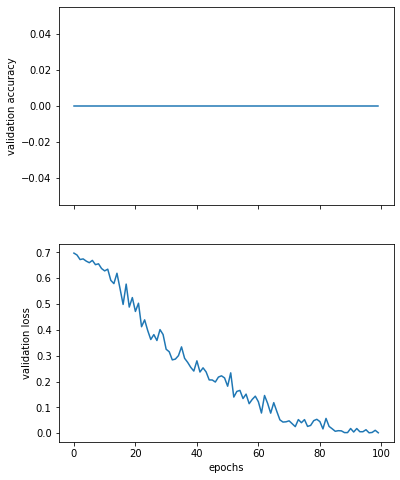

In [37]:
def plot_history(loss_list,  accuracy_list):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8), sharex=True)

  ax1.plot(accuracy_list)
  ax1.set_ylabel("validation accuracy")
  ax2.plot(loss_list)
  ax2.set_ylabel("validation loss")
  ax2.set_xlabel("epochs")
  plt.show()

  return

plot_history(loss_list,  accuracy_list) 

# Identificação da Acurácia

In [38]:
test = DataLoader(test_dataset, batch_size=len(test_dataset),shuffle=True)
#test = DataLoader(test_dataset, batch_size=16,shuffle=True)
xx_test, yy_test = next(iter(test))

In [39]:
yy_pred = model(xx_test).round()

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(yy_test.detach().numpy(), yy_pred.detach().numpy()))

0.8441558441558441


#Conclusão
Após o desenvolvimento o modelo apresenta acuracidade acima de .8 com 84,4%, para tanto foram utilizadas 2 tecnicas, sendo:

Dropout entre as camadas de entrada e saida de 0.2

L2 no otimizador ADAM com weight_decay=1E-3

Acuracidade antes da aplicação dos otimizadores éra de 68,75%

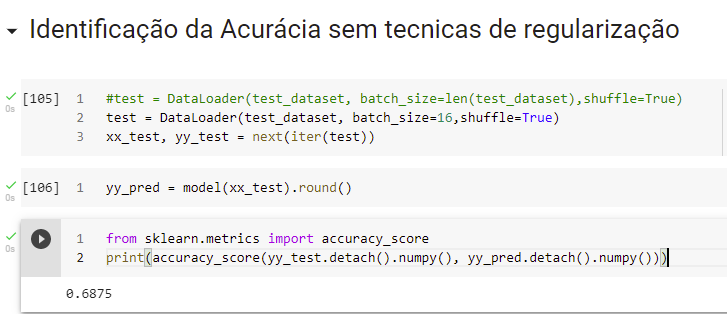